## Getting started with the Converse API in Amazon Bedrock

In this notebook, we'll explore the basics of the Converse API in Amazon Bedrock. The Converse or ConverseStream API is a unified structured text API action that allows you simplifying the invocations to Bedrock LLMs, using a universal syntax and message structured prompts for any of the supported model providers.

In the cells below we will start with installing or updating boto3. You just need to run this cell the first time.

***

## System Prompts With Different LLMs

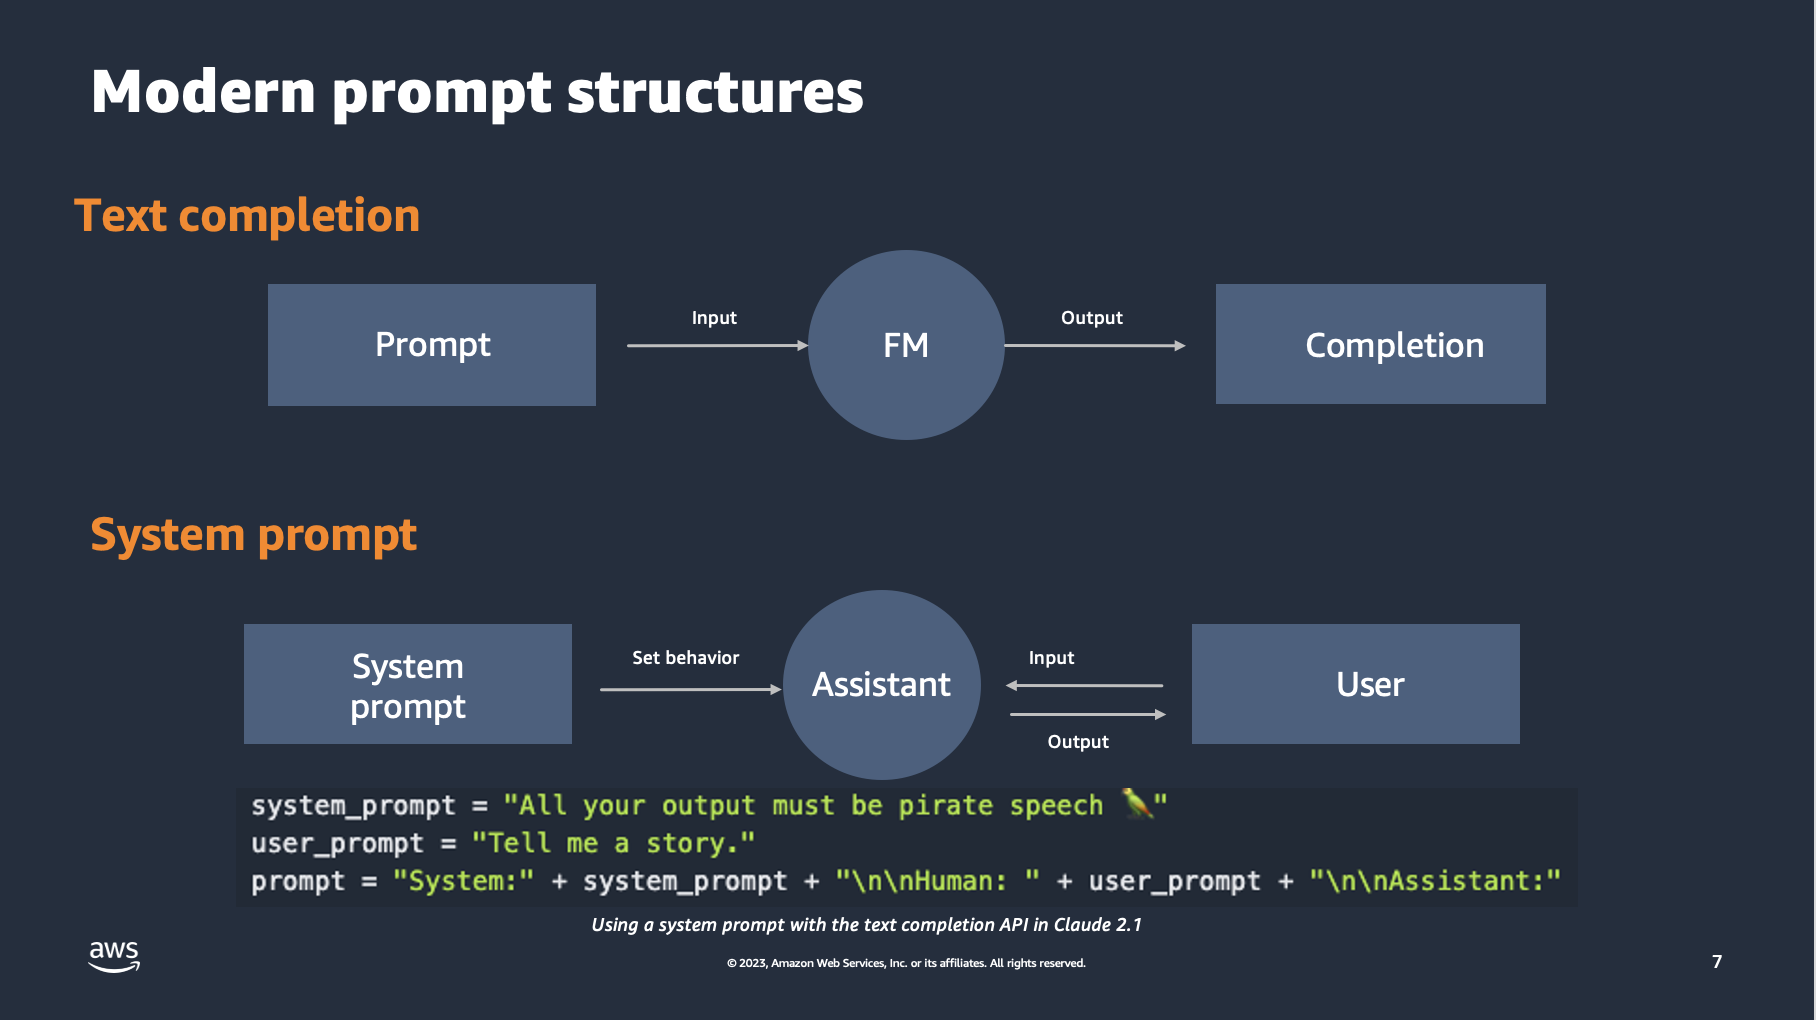

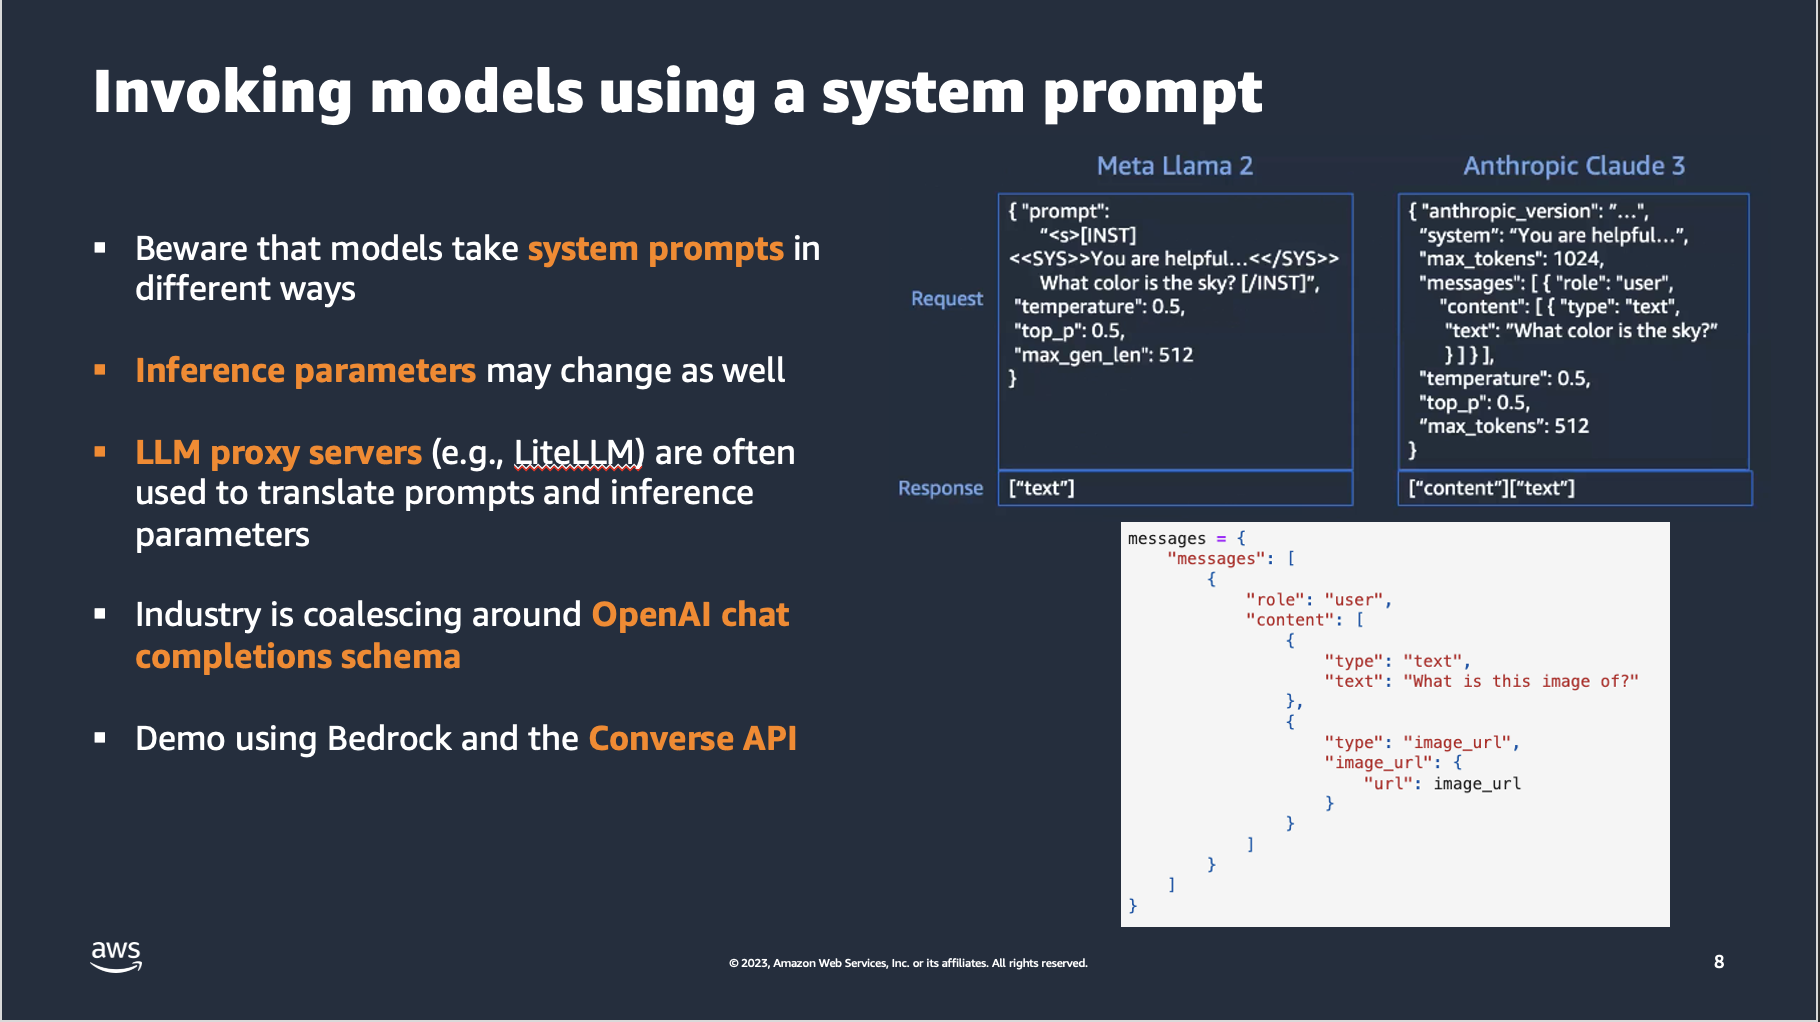

***

## Dependencies

In [ ]:
!pip3 install -qU boto3

In [ ]:
import boto3
import sys
import json
import base64
import os

print('Running boto3 version:', boto3.__version__)

***

## Model invocation through the Bedrock runtime client

In [ ]:
region = 'us-west-2' # To access to Llama 3.1
print('Using region: ', region)

bedrock = boto3.client(
    service_name = 'bedrock-runtime',
    region_name = region,
    )

***

### Using Llama 2

Llama 2 has a particular syntax for sharing instructions (system prompts) with the model. Here is an example of what the request would look like:

```
<s>[INST] <<SYS>>You are a helpful AWS Solutions Architect. You provide step-by-step instructions for architectural designs. You explain all of your architectural decisions based on expected performance and cost.<</SYS>>

[INST]Please give me detailed instructions to enable auto-scaling in Amazon SageMaker endpoints using the size of the queue in Amazon SQS[/INST]

```

In [ ]:
model_id = "meta.llama2-13b-chat-v1"

prompt = """<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

How can I reboot my Mac laptop? [/INST]"""

native_request = {
        "prompt": prompt,
        "max_gen_len": 2000,
        "temperature": 0.1,
        "top_p": 0.9
    }

# Using the `invoke_model` function
response = bedrock.invoke_model(modelId=model_id, body = json.dumps(native_request))
generated_response = json.loads(response.get('body').read())

print(generated_response['generation'])

***

### Using Claude 3 Sonnet

Claude 3 Sonnet has a particular syntax for sharing instructions (system prompts) with the model in addition to user and assistant prompts. Here is an example of what the request would look like:

```
“system”: “You’re an IT expert. Always respond with simple and direct answers in a single sentence.”,
“messages”: [
{
    “role”: “user”,
    “content”: “How can I reboot my Mac laptop?”
} ,
{
    “role”: “assistant”,
    “content”: “To reboot your Mac laptop,”
}
```

In [ ]:
system_prompt = "You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."
user_prompt = "How can I reboot my Mac laptop?"

def invoke_model(system_prompt, user_prompt):
    client = boto3.client(service_name='bedrock-runtime',
                          region_name=os.environ.get("AWS_REGION"),)
    payload = {
        "modelId": "anthropic.claude-3-sonnet-20240229-v1:0",
        "contentType": "application/json",
        "accept": "application/json",
        "body": {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 2000,
            "system": system_prompt,
            #"stop_sequences": ["```\n"],
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": user_prompt
                        }
                    ]
                }
            ]
        }
    }
    
    # Convert the payload to bytes
    body_bytes = json.dumps(payload['body']).encode('utf-8')
    response = client.invoke_model(
        body=body_bytes,
        modelId=payload['modelId'],
        accept=payload['accept'],
        contentType=payload['contentType']
    )
    
    response = json.loads(response['body'].read().decode('utf-8'))
    return response.get("content")[0]['text']

In [ ]:
response = invoke_model(system_prompt, user_prompt)
print(response)

***

## Setting Up Converse API

In [ ]:
def converse_call(client, id, prompt, system_prompts, max_tokens=2000, temperature=0, top_p=0.9):
    response = ""
    try:
        response = client.converse(
            modelId=id,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "text": prompt
                        }
                    ]
                }
            ],
            system=system_prompts,
            inferenceConfig={
                "temperature": temperature,
                "maxTokens": max_tokens,
                "topP": top_p
            }
            #additionalModelRequestFields={
            #}
        )
    except Exception as e:
        print(e)
        result = "Model invocation error"
    try:
        result = response['output']['message']['content'][0]['text'] \
        + '\n--- Latency: ' + str(response['metrics']['latencyMs']) \
        + 'ms - Input tokens:' + str(response['usage']['inputTokens']) \
        + ' - Output tokens:' + str(response['usage']['outputTokens']) + ' ---\n'
        return result
    except Exception as e:
        print(e)
        result = "Output parsing error"
    return result

In [ ]:
prompt = ("How can I reboot my Mac laptop?")

system_prompts = [{"text": "You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature."
                       "If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."}]

***

### Using Llama 2 with Converse API

In [ ]:
model_id = "meta.llama2-13b-chat-v1"

response = converse_call(bedrock, model_id, prompt, system_prompts)
print(f'Model: {model_id}\n{response}')

### Using Claude 3 Sonnet with Converse API

We can try the same prompts with Claude 3 Sonnet without having to reformat the prompt or change the inference parameters in the dictionary.

In [ ]:
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

response = converse_call(bedrock, model_id, prompt, system_prompts)
print(f'Model: {model_id}\n{response}')

### Using Llama 3.1 with Converse API

And we can change back to the Llama family without having to reformat the prompt.

In [ ]:
model_id = "meta.llama3-1-70b-instruct-v1:0"

response = converse_call(bedrock, model_id, prompt, system_prompts)
print(f'Model: {model_id}\n{response}')